In [395]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
pd.set_option('display.max_row', 1000)
import os

# Any results you write to the current directory are saved as output.

In [396]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor

In [397]:
game_data = pd.read_csv("game_data.csv")
player_data = pd.read_csv("player_data.csv")
training_data = pd.read_csv("training_set.csv", parse_dates = ['Game_Date'])
#test_data = pd.read_csv("test_set.csv", parse_dates = ['Game_Date'])

In [398]:
#note to self, add date data, w/l, all-star to training data, city populations?
#Also add social media followings? For both players and teams

[game_data.shape, player_data.shape, training_data.shape]

[(4920, 16), (77392, 23), (280625, 7)]

c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


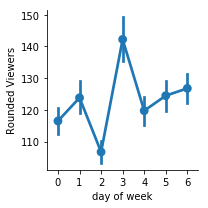

In [399]:
training_data['day of week'] = training_data.Game_Date.dt.dayofweek
g = sns.FacetGrid(training_data)
g.map(sns.pointplot, 'day of week',  'Rounded Viewers')



In [400]:
# just double checking that the graph was correct
training_data[['day of week', 'Rounded Viewers']].groupby(['day of week']).mean()

,Rounded Viewers
day of week,
0,116.475991
1,123.798095
2,106.700065
3,142.218299
4,119.721290
5,124.461662
6,126.770177


In [401]:
#checking the outliers possibly, it was on a tuesday?

training_data.loc[training_data['Rounded Viewers'].idxmax()]

Season                         2017-18
Game_ID                       21700001
Game_Date          2017-10-17 00:00:00
Away_Team                          BOS
Home_Team                          CLE
Country                           C176
Rounded Viewers                  18600
day of week                          1
Name: 145547, dtype: object

In [402]:
training_data['weekend'] = np.where(training_data.Game_Date.dt.dayofweek > 3, 1, 2)

c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


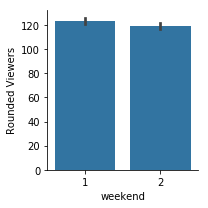

In [403]:
g = sns.FacetGrid(training_data)
g.map(sns.barplot, 'weekend',  'Rounded Viewers')

In [404]:
training_data.set_index("Game_ID", inplace = True)

In [405]:
total_views = training_data.groupby('Game_ID')['Rounded Viewers'].sum()

In [406]:
training_data['Total_Views'] = total_views

In [407]:
del total_views

# Getting rid of country/view columns


In [408]:
training_data.drop(['Rounded Viewers', 'Country'], inplace = True, axis = 1)

In [409]:
training_data.drop_duplicates(inplace = True)

In [410]:
training_data['weekend'] = np.where(training_data.Game_Date.dt.dayofweek > 3, 1, 0)
player_data['AllStar'] = np.where(player_data.ASG_Team != "None", 1, 0)

In [411]:
player_data.set_index('Game_ID', inplace = True)

In [412]:
allstar = player_data.groupby('Game_ID')['AllStar'].sum()
training_data['AllStar'] = allstar

c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


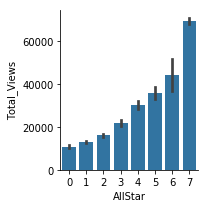

In [413]:
g = sns.FacetGrid(training_data)

g.map(sns.barplot, 'AllStar',  'Total_Views')

# There is a relationship between number of all stars and viewer count as seen here

Now we are going to try model on top of this. First is random forest. Our test model will be just a split of 0.25

In [414]:
from sklearn.model_selection import train_test_split

In [415]:
def randomforest(training_data):
    X = training_data.copy()
    y = X['Total_Views']
    X.drop(["Total_Views", "Away_Team", "Home_Team", "Game_Date", "Season"], axis = 1, inplace = True)
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
    randomforest = RandomForestRegressor(random_state = 0, n_estimators=20, min_samples_leaf= 3)
    randomforest.fit(train_X, train_y)
    randomforest_predictions = randomforest.predict(val_X)
    mape = np.mean(np.abs((val_y - randomforest_predictions) / val_y)) * 100
    print(mape)
    del randomforest_predictions
    del X, y

In [416]:
from xgboost import XGBRegressor

In [417]:
def xgboost(training_data):
    X = training_data.copy()
    y = X['Total_Views']
    X.drop(["Total_Views", "Away_Team", "Home_Team", "Game_Date", "Season"], axis = 1, inplace = True)
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
    xgboost = XGBRegressor()
    xgboost.fit(train_X, train_y)
    xgboostpredict = xgboost.predict(val_X)
    mape = np.mean(np.abs((val_y - xgboostpredict) / val_y)) * 100
    print(mape)
    del xgboostpredict
    del X, y

In [418]:
training_data['2016-17_season'] = training_data['Season'] == '2016-17'

In [419]:
randomforest(training_data)

52.8908369057


c:\users\cseuser\appdata\local\programs\python\python36-32\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


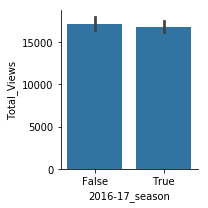

In [420]:
g = sns.FacetGrid(training_data)
g.map(sns.barplot, '2016-17_season',  'Total_Views')

# Adding population of cities to their teams

In [421]:

population_of_city = {'CLE': 2055612, 'NYK': 10153634, 'POR': 2424955,'UTA': 1186187, 'GSW': 4679166, 'SAS': 2429609, 'MIA':  6066387,
                     'ORL': 2441257, 'DAL': 7233323, 'IND': 2004230, 'BOS': 4794447, 'BKN': 10000000, 'TOR': 5928040, 'DET': 4297617,
                     'MIL': 1572482, 'MEM': 1342842, 'NOP': 1268883, 'DEN': 2853077, 'PHI': 6070500, 'OKC': 1373211, 'PHX': 4661537, 
                     'SAC': 2296418, 'HOU': 6772470, 'LAL': 13310447, 'ATL': 5789700, 'WAS': 6131977, 'CHI': 9512999, 'LAC': 13310446,
                     'CHA': 2474314, 'MIN': 3551036 }


game_data['Team_population'] = game_data['Team'].map(population_of_city)
game_data.columns

Index(['Season', 'Game_ID', 'Game_Date', 'Team', 'Location',
       'Wins_Entering_Gm', 'Losses_Entering_Gm', 'Team_Minutes', 'Final_Score',
       'Lead_Changes', 'Ties', 'Largest_Lead', 'Full_Timeouts',
       'Short_Timeouts', 'Qtr_4_Score', 'L2M_Score', 'Team_population'],
      dtype='object')

In [422]:
training_data['Total_population'] = game_data.groupby('Game_ID')['Team_population'].sum()

In [423]:
randomforest(training_data)


49.0538765222


In [424]:
game_data.set_index('Game_ID', inplace = True)

In [425]:
training_data['Home_team_population']= game_data.loc[game_data['Location'] == 'H', ['Team_population']]

In [426]:
randomforest(training_data)

47.0821668554


In [427]:
xgboost(training_data)

47.8233913392


In [428]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

In [429]:
def cross_val(training_data):
    X = training_data.copy()
    y = X['Total_Views']
    X.drop(["Total_Views", "Away_Team", "Home_Team", "Game_Date", "Season"], axis = 1, inplace = True)
    crossvalpipe = make_pipeline(RandomForestRegressor(random_state = 0, n_estimators=20, min_samples_leaf= 3))
    crossvalpredictor = cross_val_score(crossvalpipe, X, y, scoring = 'neg_mean_absolute_error')
    print(crossvalpredictor)

In [430]:
cross_val(training_data)

[-6330.32067464 -6964.30559658 -7232.02889674]


# results are pretty bad still... Going to try using one hot encoding on the teams

In [431]:
one_hot_predictors = pd.get_dummies(training_data)

In [432]:
def randomforesttwo(training_data):
    X = training_data.copy()
    y = X['Total_Views']
    X.drop(["Total_Views", "Game_Date", '2016-17_season'], axis = 1, inplace = True)
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, test_size = 0.25)
    randomforest = RandomForestRegressor(random_state = 0, n_estimators=100, min_samples_leaf= 1)
    randomforest.fit(train_X, train_y)
    randomforest_predictions = randomforest.predict(val_X)
    mape = np.mean(np.abs((val_y - randomforest_predictions) / val_y)) * 100
    print(mape)
    del randomforest_predictions
    del X, y

In [433]:
randomforesttwo(one_hot_predictors)

38.5502461603


In [434]:
def xgboosttwo(training_data):
    X = training_data.copy()
    y = X['Total_Views']
    X.drop(["Total_Views", "Game_Date", '2016-17_season'], axis = 1, inplace = True)
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1, test_size = 0.25)
    xgboost = XGBRegressor(n_estimators=2000, learning_rate = 0.05 )
    xgboost.fit(train_X, train_y, early_stopping_rounds = 10, eval_set = [(val_X, val_y)], verbose = False)
    xgboostpredict = xgboost.predict(val_X)
    mape = np.mean(np.abs((val_y - xgboostpredict) / val_y)) * 100
    print(mape)
    del xgboostpredict
    del X, y

In [435]:
xgboosttwo(one_hot_predictors)

42.3845414783


In [436]:
game_data['Total_games'] = game_data[[ 'Wins_Entering_Gm', 'Losses_Entering_Gm']].sum(axis = 1)

In [437]:
game_data['First_game'] = np.where(game_data['Total_games'] == 0, 1, 0)

In [438]:
game_data['First_week'] = np.where(game_data['Total_games'] < 3, 1, 0)

In [439]:
one_hot_predictors['First_game'] = game_data.loc[game_data['Location'] == 'H', ['First_game']]

In [440]:
one_hot_predictors['Total_games_home'] = game_data.loc[game_data['Location'] == 'H', ['Total_games']]


In [441]:
one_hot_predictors['Total_games_away'] = game_data.loc[game_data['Location'] == 'A', ['First_game']]

In [442]:
one_hot_predictors['First_week'] = game_data.loc[game_data['Location'] == 'H', ['First_week']]

In [443]:
randomforesttwo(one_hot_predictors)

33.8377513888


In [444]:
xgboosttwo(one_hot_predictors)

31.9823569356


In [445]:
game_data['wins-losses'] = game_data['Wins_Entering_Gm'] - game_data['Losses_Entering_Gm']

In [446]:
one_hot_predictors['wins-losses_home'] = game_data.loc[game_data['Location'] == 'H', ['wins-losses']]

In [447]:
one_hot_predictors['wins-losses_away'] = game_data.loc[game_data['Location'] == 'A', ['wins-losses']]

In [448]:
randomforesttwo(one_hot_predictors)

33.1978607559


In [449]:
xgboosttwo(one_hot_predictors)

32.0479872792


In [450]:
one_hot_predictors['wins-losses_away'].nunique()

88

In [451]:
one_hot_predictors['wins-losses_away'].describe()

count    2000.00000
mean       -0.01850
std        13.62057
min       -42.00000
25%        -8.00000
50%         0.00000
75%         7.00000
max        50.00000
Name: wins-losses_away, dtype: float64

In [452]:
def simplify_win_loss(df):
    bins = (-50, -35 , -25, -15, -5, 0, 5, 15, 25, 35, 50)
    group_names = ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k']
    categories = pd.cut(df['wins-losses_away'], bins, labels = group_names)
    df['wins-losses_away'] = categories
    return df

In [453]:
test = simplify_win_loss(one_hot_predictors.copy())

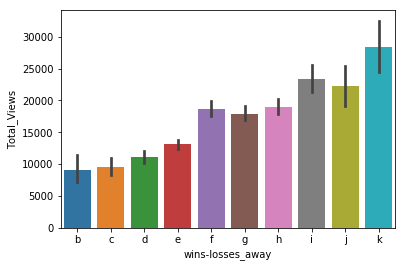

In [454]:
sns.barplot(x = 'wins-losses_away', y = 'Total_Views', data = test)

In [455]:
from sklearn import preprocessing

In [456]:
def encoding(df):
    le = preprocessing.LabelEncoder()
    le = le.fit(df['wins-losses_away'])
    df['wins-losses_away'] = le.transform(df['wins-losses_away'])
    return df

In [457]:
encoding(test)

,Game_Date,day of week,weekend,Total_Views,AllStar,2016-17_season,Total_population,Home_team_population,Season_2016-17,Season_2017-18,...,Home_Team_SAS,Home_Team_TOR,Home_Team_UTA,Home_Team_WAS,First_game,Total_games_home,Total_games_away,First_week,wins-losses_home,wins-losses_away
Game_ID,,,,,,,,,,,,,,,,,,,,,
21600001,2016-10-25,1,0,57691,4,True,12209246,2055612,1,0,...,0,0,0,0,1,0,1,1,0,4
21600003,2016-10-25,1,0,60428,5,True,7108775,4679166,1,0,...,0,0,0,0,1,0,1,1,0,4
21600002,2016-10-25,1,0,40740,1,True,3611142,2424955,1,0,...,0,0,0,0,1,0,1,1,0,4
21600006,2016-10-26,2,0,23947,1,True,14794447,4794447,1,0,...,0,0,0,0,1,0,1,1,0,4
21600008,2016-10-26,2,0,12046,2,True,4046796,1572482,1,0,...,0,0,0,0,1,0,1,1,0,4
21600005,2016-10-26,2,0,33922,1,True,9237553,2004230,1,0,...,0,0,0,0,1,0,1,1,0,4
21600007,2016-10-26,2,0,14887,2,True,10225657,5928040,1,0,...,0,1,0,0,1,0,1,1,0,4
21600013,2016-10-26,2,0,34087,1,True,20082917,13310447,1,0,...,0,0,0,0,1,0,1,1,0,4
21600004,2016-10-26,2,0,22756,0,True,8507644,2441257,1,0,...,0,0,0,0,1,0,1,1,0,4


In [458]:
randomforesttwo(test)

33.2222806595


# Doesn't help much because every team starts off at 0-0. Maybe instead add previous season record

In [459]:
one_hot_predictors.drop(['wins-losses_home', 'wins-losses_away'], axis = 1, inplace = True)

In [460]:
del test

In [461]:
game_data['last_5_games'] = np.where(game_data['Total_games'] > 76, 1, 0)

In [462]:
one_hot_predictors['last_5_games'] = game_data.loc[game_data['Location'] == 'H', ['last_5_games']]

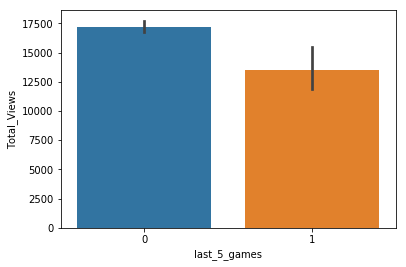

In [463]:
sns.barplot(x = 'last_5_games', y = 'Total_Views', data = one_hot_predictors)

# Doesn't help much either

In [464]:
one_hot_predictors.drop(["last_5_games"], axis = 1, inplace = True)

In [465]:
game_data['week'] =  game_data['Total_games'] // 5

In [466]:
one_hot_predictors['week'] = game_data.loc[game_data['Location'] == 'H', ['week']]

In [467]:
randomforesttwo(one_hot_predictors)

33.7404350911


# Add 16-17 standings split eastern/western

In [468]:
easternconference = {'CLE': True, 'NYK': True, 'POR': False,'UTA': False, 'GSW': False, 'SAS': False, 'MIA': True,
                     'ORL': True, 'DAL': False, 'IND': True, 'BOS': True, 'BKN': True , 'TOR': True, 'DET': True,
                     'MIL': True, 'MEM': False, 'NOP': False, 'DEN': False, 'PHI': True, 'OKC': False, 'PHX': False, 
                     'SAC': False, 'HOU': False, 'LAL': False, 'ATL': True, 'WAS': True, 'CHI':True, 'LAC': False,
                     'CHA': True, 'MIN': False }


game_data['eastern'] = game_data['Team'].map(easternconference)
game_data.columns

Index(['Season', 'Game_Date', 'Team', 'Location', 'Wins_Entering_Gm',
       'Losses_Entering_Gm', 'Team_Minutes', 'Final_Score', 'Lead_Changes',
       'Ties', 'Largest_Lead', 'Full_Timeouts', 'Short_Timeouts',
       'Qtr_4_Score', 'L2M_Score', 'Team_population', 'Total_games',
       'First_game', 'First_week', 'wins-losses', 'last_5_games', 'week',
       'eastern'],
      dtype='object')

In [469]:
one_hot_predictors['eastern'] = game_data.loc[game_data['Location'] == 'H', ['eastern']]

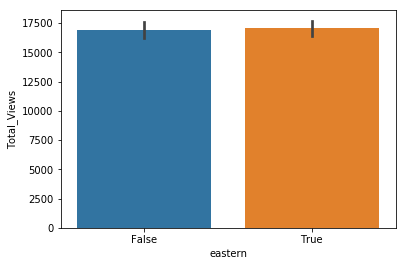

In [470]:
sns.barplot(x = 'eastern', y = 'Total_Views', data = one_hot_predictors)

# no difference

In [471]:
randomforesttwo(one_hot_predictors)

33.7550032382


In [472]:
one_hot_predictors.drop('eastern', axis = 1, inplace = True)

In [473]:
xgboosttwo(one_hot_predictors)

31.9823569356


In [474]:
rankinginconference = {'CLE': 1, 'NYK': 3, 'POR': 3,'UTA': 1, 'GSW': 1, 'SAS': 3, 'MIA': 3,
                     'ORL': 5, 'DAL': 5, 'IND': 3, 'BOS': 1, 'BKN': 5 , 'TOR': 2, 'DET': 5,
                     'MIL': 2, 'MEM': 3, 'NOP': 4, 'DEN': 4, 'PHI': 4, 'OKC': 2, 'PHX': 5, 
                     'SAC': 3, 'HOU': 2, 'LAL': 4, 'ATL': 2, 'WAS': 1, 'CHI': 4, 'LAC': 4,
                     'CHA': 4, 'MIN': 5 }


game_data['ranking'] = game_data['Team'].map(rankinginconference)
game_data.columns

Index(['Season', 'Game_Date', 'Team', 'Location', 'Wins_Entering_Gm',
       'Losses_Entering_Gm', 'Team_Minutes', 'Final_Score', 'Lead_Changes',
       'Ties', 'Largest_Lead', 'Full_Timeouts', 'Short_Timeouts',
       'Qtr_4_Score', 'L2M_Score', 'Team_population', 'Total_games',
       'First_game', 'First_week', 'wins-losses', 'last_5_games', 'week',
       'eastern', 'ranking'],
      dtype='object')

In [475]:
one_hot_predictors['home_ranking'] = game_data.loc[game_data['Location'] == 'H', ['ranking']]
one_hot_predictors['away_ranking'] = game_data.loc[game_data['Location'] == 'A', ['ranking']]

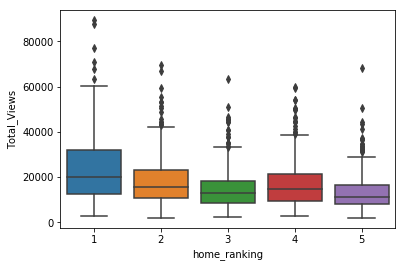

In [476]:
sns.boxplot('home_ranking', 'Total_Views', data = one_hot_predictors)

In [477]:
xgboosttwo(one_hot_predictors)

32.3643879561


In [478]:
one_hot_predictors['average_ranking'] = ( one_hot_predictors['home_ranking'] + one_hot_predictors['away_ranking']) / 2

In [479]:
randomforesttwo(one_hot_predictors)

34.2159130297


In [480]:
xgboosttwo(one_hot_predictors.drop(['average_ranking', 'Total_games_away', 'week'], axis = 1))

31.691880476


In [481]:
rankinginconference = {'CLE': 4, 'NYK': 11, 'POR': 3,'UTA': 5, 'GSW': 2, 'SAS': 12, 'MIA': 6,
                     'ORL': 14, 'DAL': 14, 'IND': 5, 'BOS': 2, 'BKN': 12 , 'TOR': 1, 'DET': 9,
                     'MIL': 7, 'MEM': 14, 'NOP': 6, 'DEN': 9, 'PHI': 3, 'OKC': 4, 'PHX': 15, 
                     'SAC': 12, 'HOU': 1, 'LAL': 11, 'ATL': 15, 'WAS': 8, 'CHI': 13, 'LAC': 10,
                     'CHA': 10, 'MIN': 8 }


game_data['rankinginconference'] = game_data['Team'].map(rankinginconference)
game_data.columns

Index(['Season', 'Game_Date', 'Team', 'Location', 'Wins_Entering_Gm',
       'Losses_Entering_Gm', 'Team_Minutes', 'Final_Score', 'Lead_Changes',
       'Ties', 'Largest_Lead', 'Full_Timeouts', 'Short_Timeouts',
       'Qtr_4_Score', 'L2M_Score', 'Team_population', 'Total_games',
       'First_game', 'First_week', 'wins-losses', 'last_5_games', 'week',
       'eastern', 'ranking', 'rankinginconference'],
      dtype='object')

In [482]:
one_hot_predictors['home_ranking_conference'] = game_data.loc[game_data['Location'] == 'H', ['rankinginconference']]
one_hot_predictors['away_ranking_conference'] = game_data.loc[game_data['Location'] == 'A', ['rankinginconference']]

one_hot_predictors['average_ranking_conference'] =  ( one_hot_predictors['home_ranking_conference'] + one_hot_predictors['away_ranking_conference']) / 2


In [483]:
xgboosttwo(one_hot_predictors.drop(['average_ranking', 'Total_games_away', 'week', 'home_ranking_conference', 'away_ranking_conference'], axis = 1))

32.2413243615


In [484]:
one_hot_predictors.drop(['home_ranking_conference', 'away_ranking_conference'], axis = 1, inplace = True)

In [485]:
xgboosttwo(one_hot_predictors)

31.3012573936


In [486]:
randomforesttwo(one_hot_predictors)

34.2625604055


In [487]:
nbawins10years = {'CLE': 1, 'NYK': 0, 'POR': 0,'UTA': 0, 'GSW': 3, 'SAS': 2, 'MIA': 2,
                     'ORL': 0, 'DAL': 1, 'IND': 0, 'BOS': 1, 'BKN': 0 , 'TOR': 0, 'DET': 0,
                     'MIL': 0, 'MEM': 0, 'NOP': 0, 'DEN': 0, 'PHI': 0, 'OKC': 0, 'PHX': 0, 
                     'SAC': 0, 'HOU': 0, 'LAL': 0, 'ATL': 0, 'WAS': 0, 'CHI': 0, 'LAC': 0,
                     'CHA': 0, 'MIN': 0 }


game_data['nbawins'] = game_data['Team'].map(nbawins10years)
game_data.columns

Index(['Season', 'Game_Date', 'Team', 'Location', 'Wins_Entering_Gm',
       'Losses_Entering_Gm', 'Team_Minutes', 'Final_Score', 'Lead_Changes',
       'Ties', 'Largest_Lead', 'Full_Timeouts', 'Short_Timeouts',
       'Qtr_4_Score', 'L2M_Score', 'Team_population', 'Total_games',
       'First_game', 'First_week', 'wins-losses', 'last_5_games', 'week',
       'eastern', 'ranking', 'rankinginconference', 'nbawins'],
      dtype='object')

In [488]:
one_hot_predictors['nbawinstotal'] = game_data.groupby('Game_ID')['nbawins'].sum()

In [489]:
randomforesttwo(one_hot_predictors)

33.8614727562


In [490]:
game_data['groups'] = np.where(game_data['rankinginconference'] >= 8, True, False)

In [491]:
one_hot_predictors['Homegroups'] = game_data.loc[game_data['Location'] == 'H', ['groups'] ]
one_hot_predictors['Awaygroups'] = game_data.loc[game_data['Location'] == 'A', ['groups'] ]
one_hot_predictors['Bothgroups'] = one_hot_predictors['Homegroups'] & one_hot_predictors['Awaygroups']

In [492]:
xgboosttwo(one_hot_predictors.drop(['average_ranking', 'Total_games_away', 'Homegroups', 'Awaygroups', 'nbawinstotal', 'Bothgroups'], axis = 1))

32.2413243615


In [493]:
randomforesttwo(one_hot_predictors)

33.9295835914


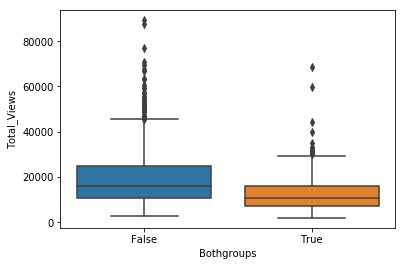

In [494]:
sns.boxplot('Bothgroups', 'Total_Views', data = one_hot_predictors)

In [495]:
xgboosttwo(one_hot_predictors.drop(['Homegroups', 'Awaygroups', 'Bothgroups', 'nbawinstotal'], axis = 1))

31.3012573936


In [496]:
one_hot_predictors.drop(['Homegroups', 'Awaygroups', 'Bothgroups', 'nbawinstotal'], axis = 1, inplace = True)